# Installing TensorFlow 2

## Building an Image Classifier Using the Sequential API

### Using Keras to Load the Dataset

Keras provides some utility functions to fetch and load common datasets, including MNIST, Fashion MNIST, the original California housing dataset, and more. Let’s load Fashion MNIST

In [1]:
import tensorflow as tf
from tensorflow import keras

In [7]:
tf.__version__

'2.5.0'

In [8]:
keras.__version__

'2.5.0'

When loading MNIST or Fashion MNIST using Keras rather than Scikit-Learn, one important difference is that every image is represented as a array rather than a 1D array of size 784

Moreover, the pixel intensities are represented as integers (from 0 to 255) rather than floats (from 0.0 to 255.0). Here is the shape and data type of the training set

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
X_train_full.shape

(60000, 28, 28)

In [5]:
X_train_full.dtype

dtype('uint8')

Note that the dataset is already split into a training set and a test set, but there is no validation set, so let’s create one

Moreover, since we are going to train the neural net work using Gradient Descent, we must scale the input features. For simplicity, we just scale the pixel intensities down to the 0-1 range by dividing them by 255.0 (this also converts them to floats)

In [6]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

With MNIST, when the label is equal to 5, it means that the image represents the handwritten digit 5. Easy. However, for Fashion MNIST, we need the list of class names to know what we are dealing with

In [9]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

For example, the first image in the training set represents a coat

In [10]:
class_names[y_train[0]]

'Coat'

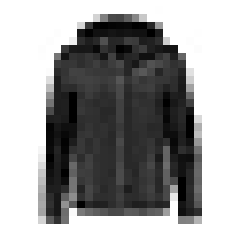

In [17]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

Let's take a look at a sample of the images in the dataset

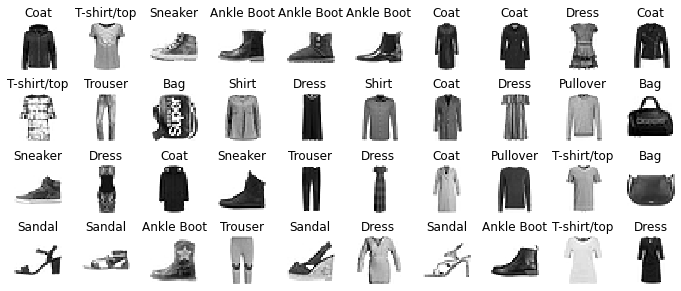

In [22]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
  for col in range(n_cols):
    index = n_cols * row + col
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
    plt.axis('off')
    plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Creating the Model Using the Sequential API

Now let’s build the neural network! Here is a classification MLP with two hidden layers

In [24]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

* The first line creates a Sequential model. This is the simplest kind of Keras model, for neural networks that are just composed of a single stack of layers, con nected sequentially. This is called the sequential API

* Next, we build the first layer and add it to the model. It is a Flatten layer whose role is simply to convert each input image into a 1D array: if it receives input data X, it computes X.reshape(-1, 1). This layer does not have any parameters, it is just there to do some simple preprocessing. Since it is the first layer in the model, you should specify the _shape: this does not include the batch size, only the input shape of the instances. Alternatively, you could add a keras.layers.InputLayer as the first layer, setting shape=[28,28] 

* Next we add a Dense hidden layer with 300 neurons. It will use the ReLU activation function. Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron)

* Next we add a second Dense hidden layer with 100 neurons, also using the ReLU  activation function

* Finally, we add a Dense output layer with 10 neurons (one per class), using the softmax activation function (because the classes are exclusive)

Instead of adding the layers one by one as we just did, you can pass a list of layers when creating the Sequential model 

In [26]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')                     
])

The model’s summary() method displays all the model’s layers, including each layer’s name (which is automatically generated unless you set it when creating the layer), its output shape (None means the batch size can be anything), and its number of parameters

The summary ends with the total number of parameters, including trainable and non-trainable parameters

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Note that Dense layers often have a lot of parameters

For example, the first hidden layer has 784 x 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters

This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data

You can easily get a model’s list of layers, to fetch a layer by its index, or you can fetch it by name

In [28]:
model.layers

In [29]:
model.layers[1].name

'dense_3'

In [30]:
model.get_layer('dense_3').name

'dense_3'

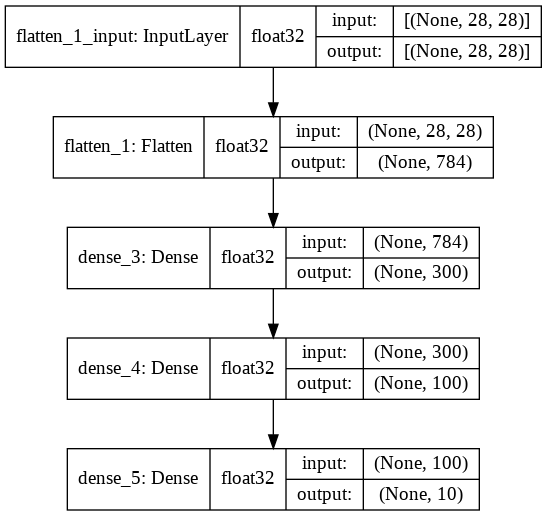

In [34]:
keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

All the parameters of a layer can be accessed using its get_weights() and set_weights() method. For a layer, this includes both the connection weights Dense and the bias terms

In [37]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()
weights

array([[-0.06729481,  0.05312541, -0.06507967, ...,  0.04898298,
        -0.04944956,  0.04633894],
       [ 0.00862657,  0.05012199,  0.0336946 , ..., -0.06708332,
         0.01988064,  0.00316714],
       [ 0.06631446, -0.03217719,  0.04592273, ...,  0.00106065,
        -0.00952111, -0.0644336 ],
       ...,
       [ 0.00591306, -0.00596189, -0.05755226, ...,  0.00667912,
        -0.01845127, -0.05673213],
       [ 0.06660014, -0.05342707,  0.01025935, ..., -0.01529054,
        -0.01451391,  0.0004333 ],
       [-0.02129421, -0.05706827,  0.04380998, ..., -0.00462902,
         0.01950054, -0.0354416 ]], dtype=float32)

In [38]:
weights.shape

(784, 300)

In [39]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [40]:
biases.shape

(300,)

Notice that the layer initialized the connection weights randomly (which is Dense needed to break symmetry, as we discussed earlier), and the biases were just initial ized to zeros, which is fine

If you ever want to use a different initialization method, you can set kernel_initializer (kernel is another name for the matrix of connection weights) or bias_initializer when creating the layer 

### Compiling the Model